In [1]:
from fastai.vision.all import *
import fastai
import timm
import albumentations as A
import torch
import pandas as pd
import numpy as np
torch.cuda.set_device(0)

In [33]:
import os
def create_csvValid(path):
    output_path = os.path.join(path,"..","df_test.csv")
    if (os.path.exists(output_path)):
        output_path_csv = open(output_path, "a")
    else:
        output_path_csv = open(output_path, "w")
        output_path_csv.write("images, class\n")

#         output_path_csv.write(head)

    lista_archivos = list(os.walk(path))
    lista_archivos.sort()
    for carpeta in lista_archivos:
#         print(carpeta[0])
        video = carpeta[0].split(os.path.sep)[-1]
        for files in carpeta[2]:
            if "images.csv" in files:
                leer = open(os.path.join(carpeta[0],files))
                leer.readline()
                for l in leer:
                    output_path_csv.write(video+os.path.sep+"images"+os.path.sep+l)
#                     print(l)

In [34]:
create_csvValid("./dataset38_Marco/test")

In [2]:
dfValid = pd.read_csv('./dataset38_Marco/df_train.csv')
dfTest = pd.read_csv('./dataset38_Marco/df_test.csv')

prueba = dfValid
prueba = prueba.iloc[np.random.permutation(len(prueba))]
prueba = prueba[0:int(len(prueba)*0.1)]
# In[6]:
# Aquí debería hacer dos df diferentes. Uno para entrenamiento y otro para validación. En este caso 
# usa para entrenar el set de entrenamiento y validación. Imagino que la división la hará por programa
# dfValid = dfValid[(dfValid.set == 'training') | (dfValid.set == 'validation')]

# Hay que modificar esto para que haya set de validación. Hacer un vector random y que esté entre las primeras 
# 0.1 posiciones si está se devuelve 
def is_valid(path):
    name = path[0]
#     return (dfValid[dfValid['challenge_id']==name])['set'].values[0]=='validation'
    return (dfValid[dfValid['images']==name]).values[0] in prueba.images.values
    
# In[13]:

def get_class(path):
    name = path[0]
    return (dfValid[dfValid['images']==name])['class']


In [3]:
dfValid.loc[:,'images']=dfValid['images'].apply(lambda x: "./dataset38_Marco/train/"+x)

In [4]:
dfTest.loc[:,'images']=dfTest['images'].apply(lambda x: "./dataset38_Marco/test/"+x)

In [5]:
dfValid['split'] = False
dfTest['split'] = True

In [6]:
dfTotal = pd.concat([dfValid,dfTest])

In [7]:
dfTotal

,images,class,split
0,./dataset38_Marco/train/IDU001V001/images/IDU001V001_from_0_to_38,0,False
1,./dataset38_Marco/train/IDU001V001/images/IDU001V001_from_19_to_57,1,False
2,./dataset38_Marco/train/IDU001V001/images/IDU001V001_from_38_to_76,1,False
3,./dataset38_Marco/train/IDU001V001/images/IDU001V001_from_57_to_95,1,False
4,./dataset38_Marco/train/IDU001V001/images/IDU001V001_from_76_to_114,1,False
...,...,...,...
7721,./dataset38_Marco/test/IDU039V006_20220212_170001/images/IDU039V006_from_1330_to_1368,12,True
7722,./dataset38_Marco/test/IDU039V006_20220212_170001/images/IDU039V006_from_1349_to_1387,12,True
7723,./dataset38_Marco/test/IDU039V006_20220212_170001/images/IDU039V006_from_1368_to_1406,12,True
7724,./dataset38_Marco/test/IDU039V006_20220212_170001/images/IDU039V006_from_1387_to_1425,12,True


In [8]:
# dfTotal.to_csv('./dataset77_Marco/df_total.csv')

In [9]:
def get_dls(presize=512,size=384,M=0,bs=16):
    db = DataBlock(blocks = (ImageBlock, CategoryBlock),
             splitter=ColSplitter(2),
             get_x = ColReader(0,suff='.jpg'),
             get_y=ColReader(1),
             item_tfms = [Resize(presize)], # CropPad(200,200)
             batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=False,flip_vert=False,
                  max_rotate=0.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)])
    dls = db.dataloaders(dfTotal,bs=bs)
    return dls

In [10]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='ConvNext_38FRAMES',monitor='cohen_kappa_score'),
    ReduceLROnPlateau(patience=10)
]

In [11]:
dlsTrain = get_dls()

learn = Learner(dlsTrain,timm.create_model('convnext_base',num_classes=13,pretrained=True),
                metrics=[accuracy,CohenKappa(weights='quadratic')],cbs = callbacks,
                loss_func= CrossEntropyLossFlat()).to_fp16()

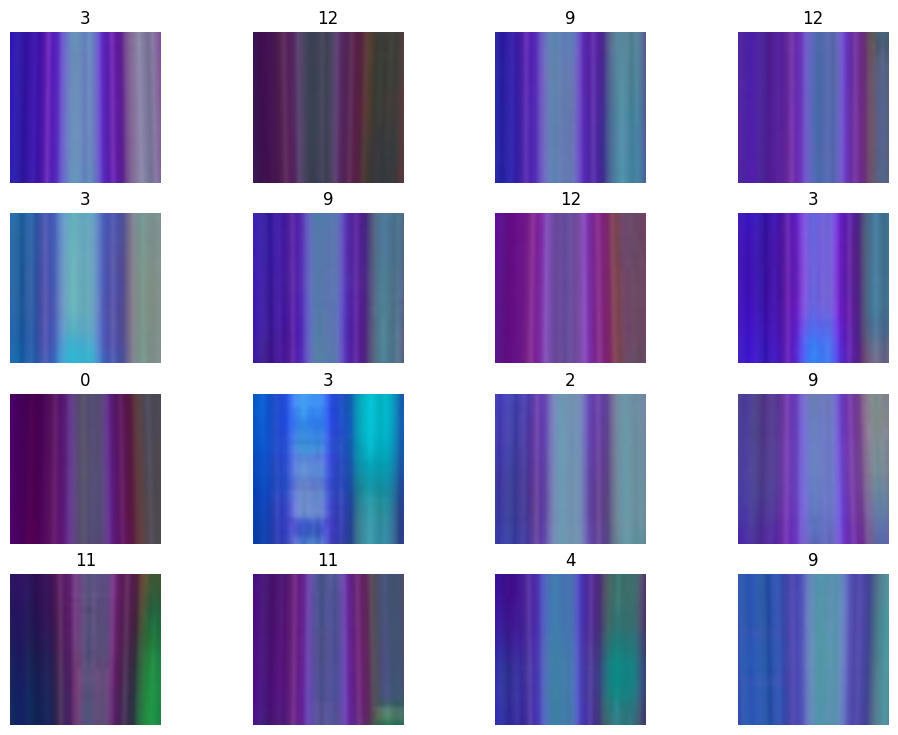

In [12]:
dlsTrain.show_batch(max_n=100, figsize=(12,9))

SuggestedLRs(valley=0.004365158267319202)

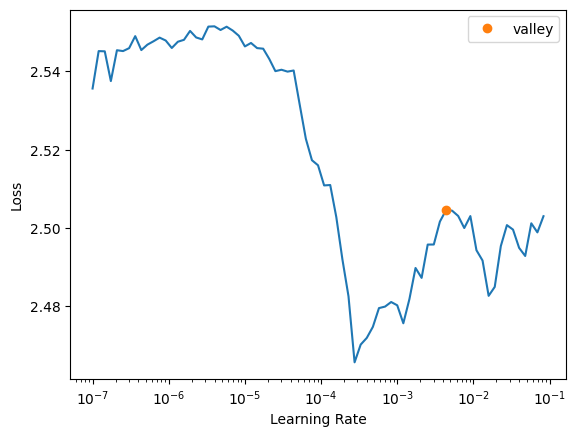

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,1.408810,1.331724,0.548279,0.671215,08:24


Better model found at epoch 0 with cohen_kappa_score value: 0.6712148073039568.


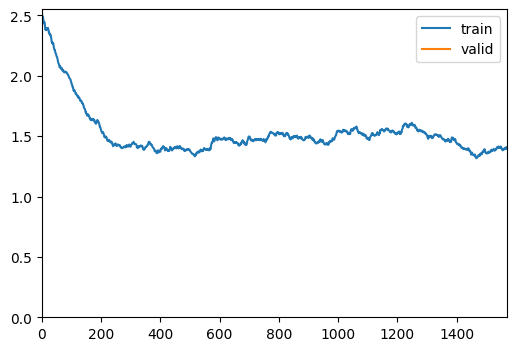

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,0.833183,0.943740,0.667228,0.814470,08:32
1,0.744510,0.924666,0.671369,0.808276,08:34
2,0.683431,0.980439,0.643153,0.809443,08:30
3,0.602784,0.975335,0.669557,0.815499,08:32
4,0.564144,1.003779,0.684183,0.827223,08:34
5,0.489442,1.006830,0.671369,0.810109,08:28
6,0.453497,1.180616,0.608077,0.776870,08:25


Better model found at epoch 0 with cohen_kappa_score value: 0.8144700699558614.


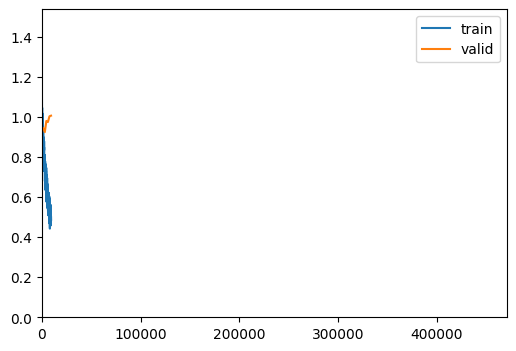

Better model found at epoch 3 with cohen_kappa_score value: 0.8154994022588969.
Better model found at epoch 4 with cohen_kappa_score value: 0.8272226855964826.
No improvement since epoch 1: early stopping


In [14]:
learn.fine_tune(300,base_lr=4e-3)

In [15]:
learn.load('ConvNext_38FRAMES')

/opt/anaconda/envs/fastai/lib/python3.10/site-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [29]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=ColSplitter('split'),
                 get_x = ColReader(0,suff='.jpg'),
                 get_y=ColReader(1),
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(dfTotal,bs=4)

In [30]:
learn.dls = dlsTest

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [31]:
learn.validate()

(#3) [1.0106189250946045,0.6737333536148071,0.8002407934320782]

In [ ]:
learn.export(fname='convNext.pkl')

In [17]:
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score

preds,gt = learn.get_preds()

In [18]:
f1_score(np.argmax(preds,axis=1),gt,average='macro')

0.6303752621172249

In [19]:
accuracy_score(np.argmax(preds,axis=1),gt)

0.684183277245664

In [20]:
with open('resultados_ConvNext_38FRAMES.txt', 'w') as f:
    f.write('El accuracy obtenido en test es:\n')
    f.write(str(accuracy_score(np.argmax(preds,axis=1),gt)))
    f.write('\nEl F1-score que tenemos en test es:\n')
    f.write(str(f1_score(np.argmax(preds,axis=1),gt,average='macro')))